In [14]:
import functools
from typing import Literal, Optional, Iterable

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import optax
import scanpy as sc
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks.layers import time_encoder
from ott.neural.networks.velocity_field import VelocityField
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm
import joypy
import pandas as pd
from ot_pert.nets.nets import VelocityFieldWithAttention
import pickle

In [2]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add

In [7]:
adata_train_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_300.h5ad"
adata_test_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_300.h5ad"
adata_ood_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_300.h5ad"

In [8]:
adata_train = sc.read(adata_train_path)
adata_ood = sc.read(adata_ood_path)
adata_test = sc.read(adata_test_path)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
confused-feather-2848

True

In [11]:
yaml_config = """
num_heads: 4
qkv_feature_dim: 16
max_seq_length: 2
hidden_dims: [1024, 1024, 1024]
output_dims: [1024, 1024, 1024, 1024]
condition_dims: [256, 256, 256]
time_dims: [512, 512, 512]
time_n_freqs: 1024
flow_noise: 1.0
learning_rate: 0.00005
multi_steps: 20
epsilon: 0.01
tau_a: 0.999
tau_b: 0.999
dropout_rate: 0.1
"""


In [12]:
import yaml
model_config = yaml.safe_load(yaml_config)


In [18]:
output_dim=300
condition_dim =1024

In [19]:
vf = VelocityFieldWithAttention(
    num_heads=model_config["num_heads"],
    qkv_feature_dim=model_config["qkv_feature_dim"],
    max_seq_length=model_config["max_seq_length"],
    hidden_dims=model_config["hidden_dims"],
    time_dims=model_config["time_dims"],
    output_dims=model_config["output_dims"] + [output_dim],
    condition_dims=model_config["condition_dims"],
    dropout_rate=model_config["dropout_rate"],
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=model_config["time_n_freqs"]),
)


model = otfm.OTFlowMatching(
    vf,
    flow=dynamics.ConstantNoiseFlow(model_config["flow_noise"]),
    match_fn=None,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(model_config["learning_rate"]), model_config["multi_steps"]),
)


2024-06-07 08:35:53.984761: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [21]:
load_path = f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/confused-feather-2848_model.pkl"

# Open the file containing the saved parameters
with open(load_path, 'rb') as f:
    loaded_params = pickle.load(f)

check_load = jax.tree_util.tree_map(lambda x,y: x.shape==y.shape, model.vf_state.params, loaded_params)
def all_values_true(d):
    if isinstance(d, dict):
        return all(all_values_true(v) for v in d.values())
    return d is True
all_values_true(check_load)

True

In [22]:
from flax.core.frozen_dict import FrozenDict
new_params = FrozenDict(loaded_params)

if hasattr(model.vf_state, 'replace'):
    model.vf_state = model.vf_state.replace(params=new_params)
else:
    raise ValueError

In [23]:
OBSM_KEY_COND_1 = "ecfp_drug_1"
OBSM_KEY_COND_2 = "ecfp_drug_2"
OBSM_KEY_DATA = "X_pca"

In [24]:
def load_data(adata):
    """Loads data and preprocesses it based on configuration."""
    dls = []
    data_source = {}
    data_target = {}
    data_source_decoded = {}
    data_target_decoded = {}
    data_conditions = {}
    source = adata[adata.obs["condition"] == "control"].obsm[OBSM_KEY_DATA]
    source_decoded = adata[adata.obs["condition"] == "control"].X

    for cond in adata.obs["condition"].cat.categories:
        if cond != "control":
            target = adata[adata.obs["condition"] == cond].obsm[OBSM_KEY_DATA]
            target_decoded = adata[adata.obs["condition"] == cond].X.A
            condition_1 = adata[adata.obs["condition"] == cond].obsm[OBSM_KEY_COND_1]
            condition_2 = adata[adata.obs["condition"] == cond].obsm[OBSM_KEY_COND_2]
            assert np.all(np.all(condition_1 == condition_1[0], axis=1))
            assert np.all(np.all(condition_2 == condition_2[0], axis=1))
            expanded_arr = np.expand_dims(
                np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
            )
            conds = np.tile(expanded_arr, (len(source), 1, 1))

            
            data_source[cond] = source
            data_target[cond] = target
            data_source_decoded[cond] = source_decoded
            data_target_decoded[cond] = target_decoded
            data_conditions[cond] = conds
    deg_dict = {k: v for k, v in adata.uns["rank_genes_groups_cov_all"].items() if k in data_conditions.keys()}

    return {
        "source": data_source,
        "target": data_target,
        "source_decoded": data_source_decoded,
        "target_decoded": data_target_decoded,
        "conditions": data_conditions,
        "deg_dict": deg_dict,
    }
    

In [25]:
test_data = load_data(adata_test) 
ood_data = load_data(adata_ood) 
    

In [26]:
reconstruct_data_fn = functools.partial(
        reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T
    )

In [27]:
predictions_test = jtu.tree_map(model.transport, test_data["source"], test_data["conditions"])

In [28]:
predictions_test.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Curcumin', 'Panobinostat+Dasatinib', 'Panobinostat+SRT1720', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Dacinostat', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+SRT2104'])

In [29]:
predictions_test_decoded = jtu.tree_map(reconstruct_data_fn, predictions_test)

In [30]:
df_preds = pd.DataFrame(data=predictions_test_decoded['Givinostat+Curcumin'], columns=adata_test.var_names)

In [31]:
adata_test.var_names

Index(['C1orf112', 'CFTR', 'KLHL13', 'TFPI', 'SLC7A2', 'CD38', 'PDK4', 'MEOX1',
       'ZFX', 'ASB4',
       ...
       'AC139493.2', 'AC007529.2', 'AL355860.1', 'AC020915.6', 'MIR3658',
       'AC006460.2', 'AL589669.1', 'AC020912.1', 'AL805961.1', 'AL031731.1'],
      dtype='object', name='gene_short_name', length=2000)

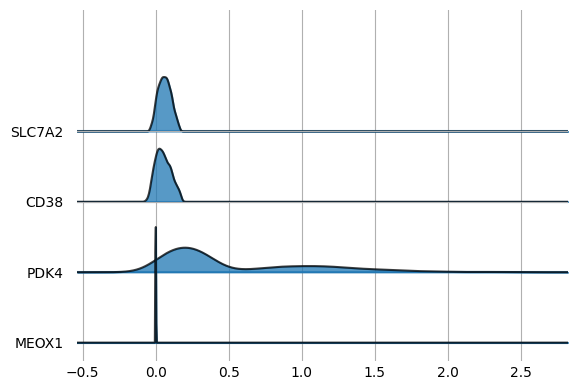

In [41]:
from ot_pert.plotting import joyplot
import seaborn as sns
from matplotlib import cm

fig, axes = joyplot(
    df_preds[['SLC7A2', 'CD38', 'PDK4', 'MEOX1']],
    #by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)

In [35]:
df_true = pd.DataFrame(data=adata_test[adata_test.obs["condition"]=='Givinostat+Curcumin'].X.A, columns=adata_test.var_names)

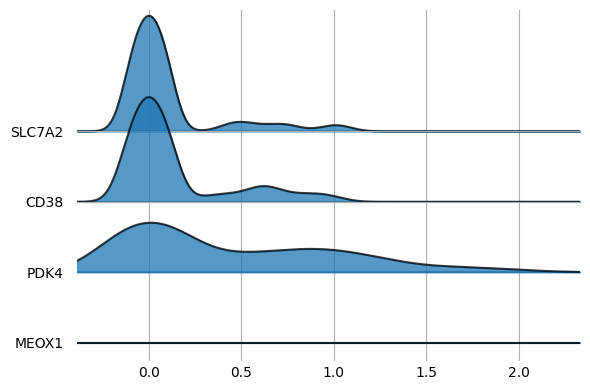

In [42]:
fig, axes = joyplot(
    df_true[['SLC7A2', 'CD38', 'PDK4', 'MEOX1']],
    #by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)

In [37]:
adata_test.obsm["X_pca"].shape

(3100, 300)